<a href="https://colab.research.google.com/github/Medynal/thing/blob/main/PRAC_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Brownfield Redevelopment Tax Credits are incentives given to encourage the clean-up and redevelopment of brownfields i.e. properties that are abandoned or underutilized due to contamination or perceived contamination.
The Department of Taxation and Finance annually produces a mandated report of taxpayers claiming Brownfield Redevelopment credit to offset their tax. The aim of this analysis is to explore the policy impact in New York City from the time the policy was implemented till 2024 (does the program improve the number of brownfields developed annually in New York City(2007-2024)?
'https://drive.google.com/file/d/1zcUPAntkZVHe3rtbC0sOX_Etv56Kdx4E/view?usp=sharing'

In [1]:
#Importing raw data
!pip -q install gdown==4.6.0
import gdown
gdrive_link = 'https://drive.google.com/file/d/1zcUPAntkZVHe3rtbC0sOX_Etv56Kdx4E/view?usp=sharing'
file_id= '1zcUPAntkZVHe3rtbC0sOX_Etv56Kdx4E'
downloadable_link= f'https://drive.google.com/uc?id={file_id}'
gdown.download(downloadable_link, output= 'NYC_brownfields.csv')
print ('download complete!' )

Downloading...
From: https://drive.google.com/uc?id=1zcUPAntkZVHe3rtbC0sOX_Etv56Kdx4E
To: /content/NYC_brownfields.csv
100%|██████████| 237k/237k [00:00<00:00, 5.96MB/s]

download complete!


This file import method was adopted to enable easy assessibilty of the raw data by future project user. The google drive link is set to public.

In [2]:
# Importing necessary frameworks
import pandas as pd
import numpy as np
import re

brownfield_df= pd.read_csv('NYC_brownfields.csv')
print(f'shape: {brownfield_df.shape}\n') #checking number of rows and columns
print(f'Missin Values:\n {brownfield_df.isna().sum()}')# Checking for missing values in each column
print('\nData Information:') # General Information
brownfield_df.info()

shape: (1461, 19)

Missin Values:
 Calendar Year                                0
Tax Year                                     0
Taxpayer Name                                0
Project Site Code                            0
Project Site Name                            0
Notes                                      389
DEC Region                                   0
County                                       0
Municipality                                 0
En-Zone                                      0
 Site Preparation Component Costs            1
Site Preparation Component Credit            1
 Tangible Property Component Costs           3
Tangible Property Component Credit           1
 OnSite Groundwater Remediation Cost         3
 OnSite Groundwater Remediation Credit       5
 Total Cost                                  1
 Total Credit                                0
Georeference                                 3
dtype: int64

Data Information:
<class 'pandas.core.frame.DataFrame'>
Ra

Column Description:
1. Calendar year: Calendar year in which the tax return was filed
2. Tax Year: Tax year of the credit claim; typically the year preceding the calendar year, although extensions and fiscal years may result in claims for a tax year being filed several calendar years later.
3. Taxpayer Name: Name of the entity earning the credit.
4. Project Site Code: Brownfield Certificate of Completion (COC) code number per the Department of Environmental Conservaction.  
5. Project Site Name: Brownfield Certificate of Completion (COC) number and site name per the Department of Environmental Conservation (DEC).
6. Notes:Remarks about the project or credit
7. DEC Region:1-9 depending on site location; code assigned by Department of Environmental Conservation corresponding to regions within NYS.
8. County:County Name
9. Municipality:City, town, borough, county, or village name where project is located For the location parameters and site description
10. En-Zone:Is site located in an Environmental Zone - Yes/No An environmental zone (EN-Zone) is an area designated as such by the Commissioner of Labor. Such areas shall be census tracts that satisfy certain poverty and unemployment metrics.
11. Site Preparation Component Costs: Generally, costs related to the remediation of a brownfield site (cleanup costs). Eligible costs differ depending on a sites date of acceptance in to the Brownfield Cleanup Program.
12. Site Preparation Component Credit: The product of the eligible site preparation costs for the qualified site multiplied by the applicable percentage.
13. Tangible Property Component Costs: Generally, costs related to the redevelopment, such as construction of a building, occurring on a brownfield site. Eligible costs differ depending on a sites date of acceptance in to the Brownfield Cleanup Program.
14. Tangible Property Component Credit: The product of the cost of qualified tangible property multiplied by the applicable percentage. The credit is also subject to varying caps dependent upon a site’s use and the amount of cleanup costs.
15. OnSite Groundwater Remediation Cost:Generally, costs related to the remediation of groundwater on a brownfield site (cleanup costs). Eligible costs differ depending on a sites date of acceptance in to the Brownfield Cleanup Program.
16. OnSite Groundwater Remediation Credit:The product of the on-site groundwater remediation costs multiplied by the applicable percentage.
17. Total Cost:The sum of component costs for the Site Preparation Credit, the Tangible Property Credit, and the OnSite Groundwater Remediation Credit.
18. Total Credit: The sum of component credits for the Site Preparation Credit, the Tangible Property Credit, and the OnSite Groundwater Remediation Credit.
19. Georeference: Open Data/Socrata-generated geocoding information from supplied address components.

Source:https://data.ny.gov/Government-Finance/Brownfield-Redevelopment-Credit-Beginning-Calendar/vud8-75x8/about_data

In [3]:
def missing_values_table(df):
    mis_val = df.isnull().sum() # Total missing values
    mis_val_percent = 100 * mis_val / len(df)  # Percentage of missing values
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table = mis_val_table.rename(columns={0: 'Missing Values', 1: '% of Total Values'})
    mis_val_table = mis_val_table.sort_values('% of Total Values', ascending=False)  # Sort the table by percentage of missing descending
    return mis_val_table

missing_values = missing_values_table(brownfield_df)
display(missing_values.style.background_gradient(cmap='Blues'))

,Missing Values,% of Total Values
Notes,389,26.625599
OnSite Groundwater Remediation Credit,5,0.342231
Tangible Property Component Costs,3,0.205339
OnSite Groundwater Remediation Cost,3,0.205339
Georeference,3,0.205339
Site Preparation Component Credit,1,0.068446
Site Preparation Component Costs,1,0.068446
Total Cost,1,0.068446
Tangible Property Component Credit,1,0.068446
Calendar Year,0,0.000000


In [4]:
#rename columns with long names for easy access.
brownfield_df.columns = brownfield_df.columns.str.strip()
brownfield_df.rename(columns={'Site Preparation Component Costs':'spc_cost',
                              'Site Preparation Component Credit':'spc_credit',
                              'Tangible Property Component Costs':'tpc_cost',
                              'Tangible Property Component Credit':'tpc_credit',
                              'OnSite Groundwater Remediation Cost':'ogrc_cost',
                              'OnSite Groundwater Remediation Credit':'ogrc_credit'},inplace=True)
# Change all column names to lower case and replace white space with '_'
brownfield_df.columns= brownfield_df.columns.str.lower().str.replace(' ', '_')

Assumption: Most credit awarded are half of the cost accrued. therefore, it is assumed that:
1.Missing credit is half of the cost if available
2.Missing cost is twice the credit, if available
3.If both are missing, then both are zero.

For missing geospatial reference, it is assumed that project with the same project site code will have the same georeference code

In [5]:
#Data Cleaning
## dealing with mising values for cost and credit
def na_values(row, a, b): #define a function that returns half of cost if credit is missing and double the credit if course is missing
    if pd.isna(row[a]) and pd.notna(row[b]):
        row[a] = row[b]*2
    elif pd.notna(row[a]) and pd.isna(row[b]):
        row[b] = row[a]/2
    elif pd.isna(row[a]) and pd.isna(row[b]):
        row[a], row[b] = 0, 0
    return row
brownfield_df = brownfield_df.apply(na_values, axis=1, args=('spc_cost', 'spc_credit'))
brownfield_df = brownfield_df.apply(na_values, axis=1, args=('tpc_cost', 'tpc_credit'))
brownfield_df = brownfield_df.apply(na_values, axis=1, args=('ogrc_cost', 'ogrc_credit'))
#filling missing total cost and total credit
total_cost = brownfield_df['spc_cost'] + brownfield_df['tpc_cost'] + brownfield_df['ogrc_cost']
total_credit = brownfield_df['spc_credit'] + brownfield_df['tpc_credit'] + brownfield_df['ogrc_credit']
brownfield_df['total_cost']= brownfield_df['total_cost'].fillna(total_cost)
##recalculating total cost and total credit due to fixed missing values
brownfield_df['total_cost']= total_cost
brownfield_df['total_credit']= total_credit


Rows with missing georeference value has the same project site code (C622031). other rows with the same project site code has a georeference of POINT (-74.98433 43.0259)


In [6]:
## show rows with missing georefernce
brownfield_df[brownfield_df['georeference'].isna()]
##check for complete rows with the same project site code
brownfield_df[brownfield_df['project_site_code']== 'C622031']
brownfield_df['georeference']= brownfield_df['georeference'].fillna('POINT (-74.98433 43.0259)')
#fill missing notes
brownfield_df['notes']= brownfield_df['notes'].fillna('No notes available')


Region code:
1 = Long Island
2 = New York City
3 = Lower Hudson Valley
4 = Capital Region/Northern Catskills
5 = Eastern Adirondacks/Lake Champlain
6 = Western Adirondacks/Eastern Lake Ontario
7 = Central New York
8 = Western Finger Lakes
9 = Western New York

Source:https://data.ny.gov/Government-Finance/Brownfield-Redevelopment-Credit-Beginning-Calendar/vud8-75x8/about_data


In [7]:
#replacing region code with region names
region_dict= {1:'Long Island',
                2:'New York City',
                3:'Lower Hudson Valley',
                4:'Capital Region/Norther Catskills',
                5:'Eastern Adirondacks/Lake Champlain',
                6:'Western Adirondacks/Eastern Lake Ontario',
                7:'Central New York',
                8:'Western Finger Lakes',
                9:'Western New York'}
brownfield_df['dec_region']= brownfield_df['dec_region'].astype(int).map(region_dict)

Notes:

1/ Information from amended return that supersedes a previously filed return; original filing removed from public report
2/ Credit form not filed so no cost data available; credit data taken from main form; site information taken from a pass-through entity
3/ The Department of Environmental Conservation (DEC) accepted this site into the Brownfield Cleanup Program on or after June 23, 2008, but prior to July 1, 2015
4/ The Department of Environmental Conservation (DEC) accepted this site into the Brownfield Cleanup Program on or after July 1, 2015
5/ Qualified site located in a Brownfield Opportunity Area
6/ Negative amounts indicate credit recapture
7/ Qualified site developed as an affordable housing project 8/ Combined entry of multiple sites. Total credit also includes credit from site C828125 River Park Commons-Townhouses. It is not possible to do site-specific costs/credit on how the credit was claimed in the aggregate

source: https://data.ny.gov/Government-Finance/Brownfield-Redevelopment-Credit-Beginning-Calendar/vud8-75x8/about_data

In [8]:
# replacing notes code with actual notes
notes_dict= {'1/':'Information from amended return that supersedes a previously filed return; original filing removed from public report',
'2/':'Credit form not filed so no cost data available; credit data taken from main form; site information taken from a pass-through entity',
'3/': 'The Department of Environmental Conservation (DEC) accepted this site into the Brownfield Cleanup Program on or after June 23, 2008, but prior to July 1, 2015',
'4/': 'The Department of Environmental Conservation (DEC) accepted this site into the Brownfield Cleanup Program on or after July 1, 2015',
'5/': 'Qualified site located in a Brownfield Opportunity Area',
'6/': 'Negative amounts indicate credit recapture',
'7/': 'Qualified site developed as an affordable housing project',
'8/': 'Combined entry of multiple sites. Total credit also includes credit from site C828125 River Park Commons-Townhouses. It is not possible to do site-specific costs/credit on how the credit was claimed in the aggregate'
}
def note(a):
  a = str(a).strip()
  matches = re.findall(r'\d+/', a)
  if matches:# Look up each note code in the dictionary and collect their meanings
    notes = [notes_dict.get(m, 'Not Available') for m in matches]
    return ', '.join(notes)
  else:
    return 'No Notes'

# Apply function notes column
brownfield_df['notes'] = brownfield_df['notes'].apply(note)







In [9]:
##recheck
brownfield_df

,calendar_year,tax_year,taxpayer_name,project_site_code,project_site_name,notes,dec_region,county,municipality,en-zone,spc_cost,spc_credit,tpc_cost,tpc_credit,ogrc_cost,ogrc_credit,total_cost,total_credit,georeference
0,2022,2021,NEW 470 LLC,C224242,New 470 Project,The Department of Environmental Conservation (...,New York City,Kings,Brooklyn,No,0.0,0.0,103861.0,15579.0,0.0,0.0,103861.0,15579.0,POINT (-73.99036 40.69245)
1,2009,2008,EMPIRE GEN HOLDINGS INC,C442035,South 40 Site,No Notes,Capital Region/Norther Catskills,Rensselaer,Rensselaer,No,700000.0,84000.0,0.0,0.0,0.0,0.0,700000.0,84000.0,POINT (-73.74127 42.64472)
2,2020,2019,NEW 470 LLC,C224242,New 470 Project,The Department of Environmental Conservation (...,New York City,Kings,Brooklyn,No,2935248.0,821869.0,0.0,0.0,0.0,0.0,2935248.0,821869.0,POINT (-73.99036 40.69245)
3,2018,2017,BLA II LLC,C915262,125 Main Street Site,The Department of Environmental Conservation (...,Western New York,Erie,Buffalo,No,0.0,0.0,43537.0,4354.0,0.0,0.0,43537.0,4354.0,POINT (-78.87846 42.88545)
4,2016,2015,BLA II LLC,C915262,125 Main Street Site,The Department of Environmental Conservation (...,Western New York,Erie,Buffalo,No,0.0,0.0,32274.0,3227.0,0.0,0.0,32274.0,3227.0,POINT (-78.87846 42.88545)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2018,2017,SENECA MARKET I LLC,C849004,Seneca Market I LLC,No Notes,Western Finger Lakes,Schuyler,Watkins Glen,Yes,0.0,0.0,10768.0,1077.0,0.0,0.0,10768.0,1077.0,POINT (-76.87373 42.38107)
1457,2024,2023,MAIN & DODGE LLC,C915341,1155 Main Street,The Department of Environmental Conservation (...,Western New York,Erie,Buffalo,Yes,0.0,0.0,67819.0,13564.0,0.0,0.0,67819.0,13564.0,POINT (-78.87846 42.88545)
1458,2017,2016,ZURENDA ENTERPRISES INC,C704045,TCMF Hillcrest Facility,No Notes,Central New York,Broome,Binghamton,No,0.0,0.0,0.0,0.0,68349.0,8202.0,68349.0,8202.0,POINT (-75.91129 42.09871)
1459,2009,2008,SENECA MARKET I LLC,C849004,Seneca Market I LLC,No Notes,Western Finger Lakes,Schuyler,Watkins Glen,Yes,1368788.0,136878.0,16040015.0,1604002.0,0.0,0.0,17408803.0,1740880.0,POINT (-76.87373 42.38107)


In [10]:
## split the georefernce to longitude and latitude
def coordinate(g):
  g= g.strip()
  pattern = r'POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)'
  match = re.search(pattern, g)
  if match:
    longitude = float(match.group(1))
    latitude = float(match.group(2))
    return pd.Series([longitude, latitude])
  else:
    return pd.Series([None, None])

brownfield_df[['longitude', 'latitude']] = brownfield_df['georeference'].apply(coordinate)


In [11]:
## checking for missing values===> No missing values!
brownfield_df[brownfield_df['longitude'].isna()]


,calendar_year,tax_year,taxpayer_name,project_site_code,project_site_name,notes,dec_region,county,municipality,en-zone,...,spc_credit,tpc_cost,tpc_credit,ogrc_cost,ogrc_credit,total_cost,total_credit,georeference,longitude,latitude


In [12]:
brownfield_dffinal= brownfield_df.copy()
## checking final data details
print(f'shape: {brownfield_dffinal.shape}\n')
print(f'Missin Values:\n {brownfield_dffinal.isna().sum()}')
print('\nData Information:')
brownfield_dffinal.info()
print('\nNumber of Unique Values in each column:')
print(brownfield_dffinal.nunique())



shape: (1461, 21)

Missin Values:
 calendar_year        0
tax_year             0
taxpayer_name        0
project_site_code    0
project_site_name    0
notes                0
dec_region           0
county               0
municipality         0
en-zone              0
spc_cost             0
spc_credit           0
tpc_cost             0
tpc_credit           0
ogrc_cost            0
ogrc_credit          0
total_cost           0
total_credit         0
georeference         0
longitude            0
latitude             0
dtype: int64

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   calendar_year      1461 non-null   int64  
 1   tax_year           1461 non-null   int64  
 2   taxpayer_name      1461 non-null   object 
 3   project_site_code  1461 non-null   object 
 4   project_site_name  1461 non-null   object 
 5   no

In [13]:
##Save cleaned data
brownfield_dffinal.to_csv('NYC_brownfields_cleaned.csv', index=False)

In [14]:
brownfield_dffinal.describe().T

,count,mean,std,min,25%,50%,75%,max
calendar_year,1461.0,2.018264e+03,4.370632e+00,2007.00000,2016.00000,2.019000e+03,2.022000e+03,2.024000e+03
tax_year,1461.0,2.017142e+03,4.390400e+00,2006.00000,2014.00000,2.018000e+03,2.021000e+03,2.023000e+03
spc_cost,1461.0,2.550610e+06,7.457799e+06,0.00000,0.00000,3.900000e+03,1.673064e+06,1.035069e+08
spc_credit,1461.0,8.498196e+05,2.252616e+06,0.00000,0.00000,9.750000e+02,4.543570e+05,3.087286e+07
tpc_cost,1461.0,1.914609e+07,7.846054e+07,-986383.00000,0.00000,2.449360e+05,9.166628e+06,2.107158e+09
tpc_credit,1461.0,2.568265e+06,7.309329e+06,-287165.00000,0.00000,3.623300e+04,1.379736e+06,8.652614e+07
ogrc_cost,1461.0,8.304080e+04,5.856726e+05,0.00000,0.00000,0.000000e+00,0.000000e+00,1.485398e+07
ogrc_credit,1461.0,2.360329e+04,1.953116e+05,0.00000,0.00000,0.000000e+00,0.000000e+00,5.788594e+06
total_cost,1461.0,2.177974e+07,7.909034e+07,-986383.00000,322044.00000,2.797966e+06,1.513998e+07,2.114478e+09
total_credit,1461.0,3.441688e+06,7.578314e+06,-268209.00000,55226.00000,5.561340e+05,3.701792e+06,8.687192e+07


Descriptive Analysis (Get to Know the Data)
In this section, the following questions will be answered to give overview of the data.

Project trend over time:How many redevelopment projects happened each year?

Total Costs vs. Credits Over Time:Are redevelopment costs and credits increasing or decreasing over the years?

Top Taxpayers/Developers: Which companies received the most credits or completed the most projects?

Regional Distribution:Which counties or DEC regions have the most brownfield projects?

In [15]:
# import necessary frameworks
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
plt.style.use('ggplot')
pio.templates.default = "ggplot2"


In [16]:
print('Overview of Brownfield Redevelopment policy from 2007 to 2024\n')
print(f'Total Number of Brownfield Developed: {brownfield_dffinal['project_site_code'].nunique()}')
print(f'Total Number of Developers: {brownfield_dffinal["taxpayer_name"].nunique()}')
print(f'Total Number of DEC Regions in NYC: {brownfield_dffinal["dec_region"].nunique()}')
print(f'Total Number of Counties in NYC: {brownfield_dffinal["county"].nunique()}')
print(f'Total Number of Municipalities in NYC: {brownfield_dffinal["municipality"].nunique()}')
print(f'Total cost of Brownfields project: ${brownfield_dffinal["total_cost"].sum():,}')
print(f'Total amount spent on groundwater remediation: ${brownfield_dffinal["ogrc_cost"].sum():,}')
print(f'Total amount spent on site preparation: ${brownfield_dffinal["spc_cost"].sum():,}')
print(f'Total amount spent on tangible property: ${brownfield_dffinal["tpc_cost"].sum():,}')
print(f'Total credit awarded: ${brownfield_dffinal["total_credit"].sum():,}')

Overview of Brownfield Redevelopment policy from 2007 to 2024

Total Number of Brownfield Developed: 530
Total Number of Developers: 605
Total Number of DEC Regions in NYC: 9
Total Number of Counties in NYC: 41
Total Number of Municipalities in NYC: 119
Total cost of Brownfields project: $31,820,206,255.0
Total amount spent on groundwater remediation: $121,322,612.0
Total amount spent on site preparation: $3,726,441,039.0
Total amount spent on tangible property: $27,972,442,604.0
Total credit awarded: $5,028,306,117.0


In [17]:
#Data Visualisation
##Project trend over time:How many redevelopment projects happened each year?
project_trend= brownfield_dffinal.groupby('calendar_year')['project_site_code'].nunique().reset_index(name= 'total_project')
#print(project_trend.head(3))
trend= px.area(data_frame= project_trend,
                       x= 'calendar_year',
                       y= 'total_project',
                       color_discrete_sequence=['#bf5824'],
                       title= 'Number of Brownfields Developed Anually',
                       labels= {'calendar_year': 'Calendar Year', 'total_project':'Total Brownfeilds Developed'},
                      hover_name= 'calendar_year',
                      markers=True,
                      height= 700)

trend.update_xaxes(tickangle=90, tick0= 2007, dtick= 1)
trend.show()
'''Fig1.1:Number of Brownfields Developed Anually'''

'Fig1.1:Number of Brownfields Developed Anually'

The chart(fig 1.1) indicates a steady annual increase in the number of Brownfield redevelopment projects, with a slight decline observed in 2019. This overall upward trend may be attributed to the implementation of Brownfield Redevelopment policies and credits, which likely encouraged more developers to participate in brownfield site redevelopment.

In [18]:
#Total Cost Vs Total Credit over time
total_cost_credit= brownfield_dffinal.groupby('calendar_year')[['total_cost', 'total_credit']].sum().reset_index()
total_cost_credit= total_cost_credit.merge(project_trend, on= 'calendar_year', how='left')
total_cost_credit= total_cost_credit.melt(id_vars= ['calendar_year','total_project'], value_vars= ['total_cost', 'total_credit'], var_name= 'type', value_name= 'amount')
total_bar= px.bar(data_frame= total_cost_credit,
                       x= 'calendar_year',
                       y= 'amount',
                       color= 'type',
                       barmode= 'group',
                      hover_data= ['total_project'],
                       color_discrete_map={'total_cost':'#2A9D8F', 'total_credit':'#bf5824'},
                       labels={'calendar_year':'Calendar Year', 'amount':'Amount', 'type':'Type'},
                       title= 'Total Cost Vs Total Credit over time')
total_bar.update_xaxes(tickangle=90, tick0= 2007, dtick= 1)
total_bar.show()
'''Fig1.2:Total Cost Vs Total Credit over time'''


'Fig1.2:Total Cost Vs Total Credit over time'

The chart (fig 1.2)illustrates the relationship between the annual total cost of Brownfield site redevelopment and the total credit awarded.This relationship is weak and inconsitent, suggesting that the amount of credit granted may not directly correspond to the total redevelopment costs each year. This infer that other factors like project eligibility, policy changes, or timing of credit disbursements affect how redevelopment costs translate into awarded credits.

Top Taxpayers/Developers – Which companies received the most credits or completed the most projects?

In [19]:
#Top taxpayer by project developed
taxpayer_counts = brownfield_dffinal.groupby(['calendar_year', 'taxpayer_name'])['project_site_code'].nunique().reset_index(name='Number_of_projects')
##Find the top taxpayer per year
top_taxpayer = taxpayer_counts.loc[taxpayer_counts.groupby('calendar_year')['Number_of_projects'].idxmax()].reset_index(drop=True)
top_taxpayer.head(3)
top_taxpayer_bar= px.bar(data_frame= top_taxpayer,
                       y= 'calendar_year',
                       x= 'Number_of_projects',
                       orientation= 'h',
                       color= 'taxpayer_name',
                       height= 800,
                       color_discrete_sequence= px.colors.qualitative.Pastel,
                       text= 'Number_of_projects',
                       labels={'calendar_year':'Calendar Year', 'Number_of_projects':'Number of Brownfields Developed', 'taxpayer_name':'Taxpayer Name'},
                       title= 'Annual Top Taxpayer by project developed')

top_taxpayer_bar.update_yaxes(tickangle=45, tick0= 2007, dtick= 1)
top_taxpayer_bar.show()
'''Fig1.3:Annual Top Taxpayer by project developed'''

'Fig1.3:Annual Top Taxpayer by project developed'

the chart (fig1.3) above illustrates taxpayers/developer with the highest number of brownfield developed annually. this highlights the consistency of ELK STREET COMMERCE PARK LLC in brownfield redevelopement underscoring its commitment to environmental restoration

In [20]:
#Top taxpayer by project credit
taxpayer_ccounts = brownfield_dffinal.groupby(['calendar_year', 'taxpayer_name'])['total_credit'].sum().reset_index()
##Find the top taxpayer per year
topc_taxpayer = taxpayer_ccounts.loc[taxpayer_ccounts.groupby('calendar_year')['total_credit'].idxmax()].reset_index(drop=True)
topc_taxpayer.head(3)
topc_taxpayer_bar= px.bar(data_frame= topc_taxpayer,
                       x= 'calendar_year',
                       y= 'total_credit',
                       color= 'taxpayer_name',
                       color_discrete_sequence= px.colors.qualitative.Pastel,
                       labels={'calendar_year':'Calendar Year', 'total_credit':'Total Credit Earned', 'taxpayer_name':'Taxpayer Name'},
                       title= 'Top Taxpayer by Total Credit Earned')

topc_taxpayer_bar.update_xaxes(tickangle=90, tick0= 2007, dtick= 1)
topc_taxpayer_bar.update_traces(hovertemplate='%{y:,}')
topc_taxpayer_bar.show()
'''Fig1.4:Annual Top Taxpayer by Total Credit Earned'''

'Fig1.4:Annual Top Taxpayer by Total Credit Earned'

2.ENVIRONMENTAL ANALYSIS

In [21]:
#Trend of brownfields developed anually based on environment zone
zone_trend= brownfield_dffinal.groupby(['calendar_year','en-zone'])['project_site_code'].nunique().reset_index()
#print(zone_trend)
zone_trend_bar= px.bar(data_frame= zone_trend,
                       x= 'calendar_year',
                       y= 'project_site_code',
                       color= 'en-zone',
                       barmode= 'group',
                       color_discrete_map={'No':'#2A9D8F', 'Yes':'#bf5824'},
                       text= 'project_site_code',
                       labels={'calendar_year':'Calendar Year', 'project_site_code':'Number of Brownfields Developed', 'en-zone':'Environmental Zone'},
                       title= 'Trend of Brownfields Developed Anually based on Environment Zone')
zone_trend_bar.update_xaxes(tickangle=90, tick0= 2007, dtick= 1)
zone_trend_bar.show()

'''Fig 2.1:Trend of Brownfields Developed Anually based on Environment Zone'''




'Fig 2.1:Trend of Brownfields Developed Anually based on Environment Zone'

This visualization (fig 2.1) shows compares number of brownfield sites developed annually in different enviromental zone. while there's a steady incresase in the total number of brownfield sites developed, there is decrease in number of brownfield developed in environmental zone and otherwise for non environmental zone. this may indicate that the policy also improve developement in environmental zones or pottential project site  in non-environmental zones have matured or reduced in number.
In conclusion, 55% of brownfield developed are in environmental Zone while 44.8% are in non environmental Zone.

In [22]:
brownfield_z= brownfield_dffinal.groupby('en-zone')['project_site_code'].nunique().reset_index(name= 'total_project')
brownfield_zone= px.pie(data_frame= brownfield_z,
                     values= 'total_project', names= 'en-zone',
                     color= 'en-zone', color_discrete_map={'No':'#2A9D8F', 'Yes':'#bf5824'} )
brownfield_zone.show()
'''Fig 2.2:Distribution of Total Brownfield developed by environmental zone'''

'Fig 2.2:Distribution of Total Brownfield developed by environmental zone'

In [23]:
## Number of Brownfields Developed so far by DEC Region
region_trend= brownfield_dffinal.groupby(['dec_region'])['project_site_code'].nunique().reset_index(name= 'Total brownfield developed')
region_trend_pie= px.pie(data_frame= region_trend, names= 'dec_region', values= 'Total brownfield developed', hover_name= 'dec_region',
                       color_discrete_sequence= px.colors.qualitative.Pastel,
                       title= 'Total of Brownfields Developed in each DEC region')

region_trend_pie.show()
'''Fig 2.3:Total of Brownfields Developed in each DEC region'''


'Fig 2.3:Total of Brownfields Developed in each DEC region'

The pie chart (fig2.3) shows the distribution of total Brownfield developments across regions, with the New York City DEC Region contributing the highest share at 41.5%.

In [24]:
region_trend= brownfield_dffinal.groupby(['calendar_year','dec_region','en-zone'])['project_site_code'].nunique().reset_index(name= 'total projects')
region_trend_bar= px.bar(data_frame= region_trend,
                       x= 'calendar_year',
                       y= 'total projects',
                       color= 'en-zone',
                       barmode= 'relative',
                       facet_col= 'dec_region',
                       facet_col_wrap= 3,
                      facet_row_spacing= 0.08,
                      facet_col_spacing= 0.08,
                       color_discrete_map={'No':'#2A9D8F', 'Yes':'#bf5824'},
                      height= 1000,
                      width= 1500,
                       #text= 'total projects',
                       labels={'dec_region':'Department of Environmental Conservation region ', 'total projects':'Number of Brownfields Developed', 'en-zone':'Environmental Zone'},
                       title= 'Total Brownfields Developed in each DEC region based on Environment Zone')
region_trend_bar.update_xaxes(tickangle=90, tick0= 2007, dtick= 1)
region_trend_bar.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1].strip()))
region_trend_bar.show()

'''Fig 2.4:Total Brownfields Developed in each DEC region based on Environment Zone'''

'Fig 2.4:Total Brownfields Developed in each DEC region based on Environment Zone'

In fig 2.4, while some DEC region like new york city, western new york city and lower hudson valley experience steady brownfield development project annually, regions like long island, eastern adirodak continue to lag behind indicating uneven redevelopemnt accross the *state*.

In [25]:
#Number of Brownfields Developed so far by DEC Region
import random
random.seed(49)
custom_colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for County in range(brownfield_dffinal['county'].nunique())]# generate distinct color for easy identification on map
fig = px.scatter_mapbox(brownfield_dffinal,
    lat='latitude',
    lon='longitude',
    hover_name='project_site_name',
    hover_data=['county', 'calendar_year'],
    color='dec_region',
    zoom=5,
    height=600,
    title='Brownfield Redevelopment Project Locations (NY)',
    color_discrete_sequence= custom_colors,
    mapbox_style= 'carto-positron'
)
fig.show()
'''Fig 2.5:Brownfield Projects Locations'''

'Fig 2.5:Brownfield Projects Locations'

The map shows the spatial distribution of Brownfield site locations across the state. Regions such as New York City, Long Island, and the Lower Hudson Valley have their Brownfield sites clustered within specific areas. This clustering may indicate historical land-use patterns and the presence of former manufacturing zones that required environmental remediation.In contrast, upstate regions show more dispersed patterns, suggesting differences in industrial history and redevelopment demand.

In [26]:
ogrc= px.scatter(data_frame= brownfield_dffinal,
                 x= 'calendar_year',
                 y= 'ogrc_cost',
                 color= 'dec_region',
                 color_discrete_sequence= custom_colors,
                 title= 'Brownfield Ground Water Remediation Cost',
                 hover_name= 'project_site_code',
                 hover_data= ['county', 'municipality'],
                 labels= {'ogrc_cost':'Ground Water Remediation Cost', 'calendar_year': 'Calender Year' })
ogrc.update_xaxes(tickangle=90, tick0= 2007, dtick= 1)
ogrc.update_yaxes(tickprefix= '$', tickangle= 90)
ogrc.update_traces(marker=dict(size=10))
ogrc.show()
'''Fig 2.6 :Brownfield Ground Water Remediation Cost'''


'Fig 2.6 :Brownfield Ground Water Remediation Cost'

fig 2.5 shows that brownfiled projects in region like new york city and western new york city shows higher groundwater remediation cost this suggests that sites in these areas may have more complex contamination issues.

In [27]:
#negative total credit are credit to be refunded back to the govermrnt. therefore dropping negative total credit
brownfield_dffinall= brownfield_dffinal[brownfield_dffinal['total_credit']>=0]
#compute percentage of cost covered by the credit
brownfield_dffinall['cost_credit_perc']= brownfield_dffinall['total_credit']* 100 /brownfield_dffinall['total_cost']


cost_credit= px.scatter(data_frame= brownfield_dffinall,
                 x= 'calendar_year',
                 y= 'cost_credit_perc',
                 color= 'dec_region',
                 color_discrete_sequence= custom_colors,
                 title= 'Brownfield Redevelopemnt cost-credit Percentage',
                 hover_name= 'project_site_code',
                 hover_data= ['county', 'municipality'],
                 labels= {'cost_credit_perc':'Cost-Credit Percentage', 'calendar_year': 'Calender Year' })
cost_credit.update_xaxes(tickangle=90, tick0= 2007, dtick= 1)
cost_credit.update_yaxes(tickprefix= '%', tickangle= 90)
cost_credit.update_traces(marker=dict(size=10))
cost_credit.show()
'''Fig 2.6(2) :Brownfield Ground Water Remediation Cost'''


/tmp/ipython-input-2156870763.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



'Fig 2.6(2) :Brownfield Ground Water Remediation Cost'

fig 2.6(2) shows that projects in these DEC Region: Western New York, New York City and Lower Hudson Valley Has higher cost-credit percentage.

In [28]:
brownfield_dffinal['housing']= brownfield_dffinal['notes'].str.contains('housing')
brownfield_z= brownfield_dffinal.groupby('housing')['project_site_code'].nunique().reset_index(name= 'total_project')
brownfield_zone= px.pie(data_frame= brownfield_z,
                     values= 'total_project', names= 'housing',
                     color= 'housing', color_discrete_map={'No':'#2A9D8F', 'Yes':'#bf5824'} )
brownfield_zone.show()
'''Fig 2.7:Housing Overview'''

'Fig 2.7:Housing Overview'

"Fig 2.7 shows that 20.4% of brownfield sites developed are converted to affordable housing, whereas the majority are allocated for commercial, industrial, or conventional residential purposes."

In [29]:
df_county= brownfield_dffinal.groupby(['dec_region','county'])['project_site_code'].nunique().reset_index(name= 'total_project')
df_countyp= px.sunburst(data_frame= df_county,values= 'total_project',names= 'county', path= ['dec_region','county'])
df_countyp.show()
'''Fig 2.8: Brownfield distribution accross counties'''

'Fig 2.8: Brownfield distribution accross counties'

3. Financial Analysis

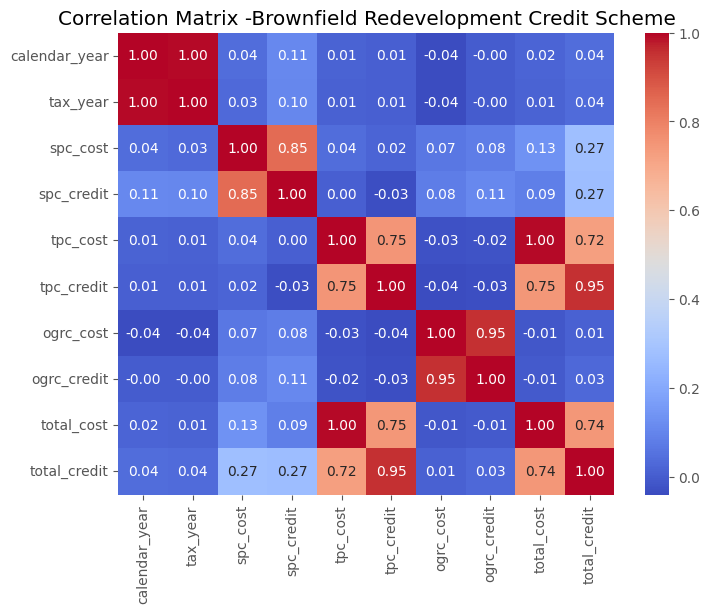

'Fig 3.1:Correlation Matrix'

In [30]:
corr= brownfield_dffinal.select_dtypes(include=['int', 'float']).drop(['longitude', 'latitude'], axis= 1).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix -Brownfield Redevelopment Credit Scheme')
plt.show()

'''Fig 3.1:Correlation Matrix'''


While the amount spent in each development stage determines the credit earned for that stage, the correlation table (fig 3.1) shows that total property component cost(tpc_cost) plays a particularly significant role in the total credit earned for a development, with a correlation coefficient of 0.72.
This indicates a strong positive relationship between total project cost and brownfield credits.

Note: Brownfield credits are calculated by tax experts and involve thorough, detailed financial assessments.

In [31]:
spread= px.box(data_frame= brownfield_dffinal,
               x= 'calendar_year', y= 'total_credit',
               color_discrete_sequence= custom_colors,
               points= False)
#colour outliers to show DEC region
import plotly.graph_objects as go
q1 = brownfield_dffinal.groupby('calendar_year')['total_credit'].transform(lambda x: x.quantile(0.25))
q3 = brownfield_dffinal.groupby('calendar_year')['total_credit'].transform(lambda x: x.quantile(0.75))
iqr = q3 - q1
whisker= 1.5 * iqr
brownfield_dffinal['is_outlier'] = (brownfield_dffinal['total_credit'] < (q1 - whisker)) | (brownfield_dffinal['total_credit'] > (q3 + whisker))
outliers = brownfield_dffinal[brownfield_dffinal['is_outlier']]
outliers_= px.scatter(data_frame= outliers,
                 x= 'calendar_year',
                 y= 'total_credit',
                color= 'dec_region',
                hover_name='project_site_code',
                color_discrete_sequence= custom_colors)
#add outlier to the boxplot
figure = go.Figure(data = spread.data + outliers_.data)
outliers_.update_traces(marker=dict(size=10))
figure.show()

'''Fig 3.2:Boxplot of Total Credit Earned'''

'Fig 3.2:Boxplot of Total Credit Earned'

In [32]:
spread= px.box(data_frame= brownfield_dffinal,
               x= 'calendar_year', y= 'total_cost',
               color_discrete_sequence= custom_colors,
               points= False)
#colour outliers to show DEC region
import plotly.graph_objects as go
q1 = brownfield_dffinal.groupby('calendar_year')['total_cost'].transform(lambda x: x.quantile(0.25))
q3 = brownfield_dffinal.groupby('calendar_year')['total_cost'].transform(lambda x: x.quantile(0.75))
iqr = q3 - q1
whisker= 1.5 * iqr
brownfield_dffinal['is_outlier'] = (brownfield_dffinal['total_cost'] < (q1 - whisker)) | (brownfield_dffinal['total_cost'] > (q3 + whisker))
outliers = brownfield_dffinal[brownfield_dffinal['is_outlier']]
outliers_= px.scatter(data_frame= outliers,
                 x= 'calendar_year',
                 y= 'total_cost',
                color= 'dec_region',
                hover_name='project_site_code',
                color_discrete_sequence= custom_colors)
#add outlier to the boxplot
figure = go.Figure(data = spread.data + outliers_.data)
#outliers_.update_traces(marker=dict(size=10))
figure.show()

'''Fig 3.3:Boxplot of Total Cost'''

'Fig 3.3:Boxplot of Total Cost'

Figures 3.2 and 3.3 show that both the total cost and the credit earned per project per year have relatively low mean values, indicating that most projects fall on the lower end of the cost and credit distribution. The presence of numerous outliers suggests that the dataset contains several high-value projects, contributing to a high level of variability. This pattern implies that while most Brownfield projects are modest in scale, a few large projects significantly influence the overall distribution.

Conclusion

This analysis provides a comprehensive view of brownfield redevelopment activities across New York State, focusing on annual development trends, environmental zone distribution, regional participation, and financial patterns. The findings reveal that brownfield redevelopment has generally increased over the years, reflecting the growing impact of state-level environmental policies and financial incentives. Although environmental zones initially showed fluctuating development activity, the overall trend indicates improved participation, suggesting the policy’s effectiveness in encouraging developers to remediate high-priority areas.

New York City, Lower Hudson Valley, and Western New York consistently lead in the number of brownfield projects, highlighting strong developer engagement and greater demand for urban redevelopment. Financial analysis shows a strong positive relationship between total project cost and total credit earned, particularly evident in the high correlation (0.72) between total property component cost (tpc_cost) and total credit. This suggests that larger, more complex projects often yield higher incentives, as intended by policy design.
Spatial analysis further indicates that brownfield sites are concentrated within specific regions, particularly New York City and Long Island, which may be influenced by industrial history, land availability, or regional economic needs. However, some regions such as Eastern Adirondack and certain rural counties show limited development activity, indicating potential gaps in uptake or accessibility.

Overall, while the Brownfield Cleanup Program appears to be driving redevelopment, regional disparity, site clustering, and project variability highlight areas where strategic policy reinforcement could enhance balanced environmental and economic outcomes.
________________________________________
Recommendations
1. Strengthen Support for Low-Activity Regions
Regions such as Eastern Adirondack and parts of Long Island show limited redevelopment. Targeted incentives such as higher credit multipliers, reduced application barriers, or technical assistance could encourage developer participation in these areas.

2. Enhance Awareness and Outreach Programs
Some developers, especially smaller firms, may lack awareness of available credits or face administrative challenges. Clearer guidelines, training workshops, and improved communication from state agencies would support wider program adoption.

4. Encourage Sustainable Redevelopment
Only about 20.4% of brownfield sites are converted to sustainable housing. Expanding incentives for green buildings, renewable energy integration, or affordable housing development could increase socially responsible outcomes.

5. Strengthen Environmental-Zone Targeting
Given that 55% of brownfield sites lie within environmental zones, continued monitoring is essential. Reviewing policy effectiveness annually can ensure these zones continue to receive priority redevelopment attention.

6. Promote Regional Collaboration
Sharing best practices among high-performing regions (e.g., NYC, Western New York) and low-performing regions can help transfer technical and administrative knowledge, improving statewide performance.

